<a href="https://colab.research.google.com/github/usha0714/Deciphering-Gender-from-Handwriting/blob/main/Mini_project_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**DATA COLLECTION AND PREPROCESSING**

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3, MobileNetV2, DenseNet121, EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [ ]:
import zipfile
import os

# Path to the zip file
zip_file_path = '/content/female.zip'
# Path to extract the contents
extract_path = '/content/extracted_folder'

# Create the extraction directory if it does not exist
os.makedirs(extract_path, exist_ok=True)

# Unzipping the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f'Files extracted to {extract_path}')

Files extracted to /content/extracted_folder


In [ ]:
import zipfile
import os

# Path to the zip file
zip_file_path = '/content/male.zip'
# Path to extract the contents
extract_path = '/content/extracted_folder'

# Create the extraction directory if it does not exist
os.makedirs(extract_path, exist_ok=True)

# Unzipping the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f'Files extracted to {extract_path}')

Files extracted to /content/extracted_folder


In [ ]:
# Data directories
data_dir = '/content/extracted_folder'

In [ ]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1  # Splitting data into training and validation
)

# Data preparation for validation and test sets
test_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.1)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=10,
    class_mode='categorical',
    subset='training'
)

Found 153 images belonging to 2 classes.


In [ ]:
validation_generator = test_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=10,
    class_mode='categorical',
    subset='validation'
)

Found 16 images belonging to 2 classes.


In [ ]:
# Retrieve class indices mapping
class_indices = train_generator.class_indices
# Reverse the mapping to get a dictionary that maps indices to class names
index_to_class = {v: k for k, v in class_indices.items()}

**FEATURE EXTRACTION**

In [ ]:
def create_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(len(class_indices), activation='softmax')(x)  # Assuming 10 classes
    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False  # Freeze the base model layers

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


**MODEL TRAINING AND EVALUATION**

In [ ]:
# List of base models to evaluate
base_models = [
    ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
]

In [ ]:
# Initialize variables to store best model and accuracy
best_model = None
best_accuracy = 0.0
model_histories = {}
model_accuracies={}

training --> resnet50
Epoch 1/40
16/16 [==============================] - 9s 289ms/step - loss: 1.2876 - accuracy: 0.6275 - val_loss: 0.5168 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 2/40
16/16 [==============================] - 2s 151ms/step - loss: 0.7576 - accuracy: 0.7255 - val_loss: 0.8600 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 3/40
16/16 [==============================] - 2s 152ms/step - loss: 0.4823 - accuracy: 0.8039 - val_loss: 0.5231 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 4/40
16/16 [==============================] - 4s 252ms/step - loss: 0.4881 - accuracy: 0.7778 - val_loss: 0.4664 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 5/40
16/16 [==============================] - 2s 149ms/step - loss: 0.5269 - accuracy: 0.7843 - val_loss: 0.6989 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/40
16/16 [==============================] - 2s 151ms/step - loss: 0.5400 - accuracy: 0.7778 - val_loss: 0.7857 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 7/40
16/16 [==============================

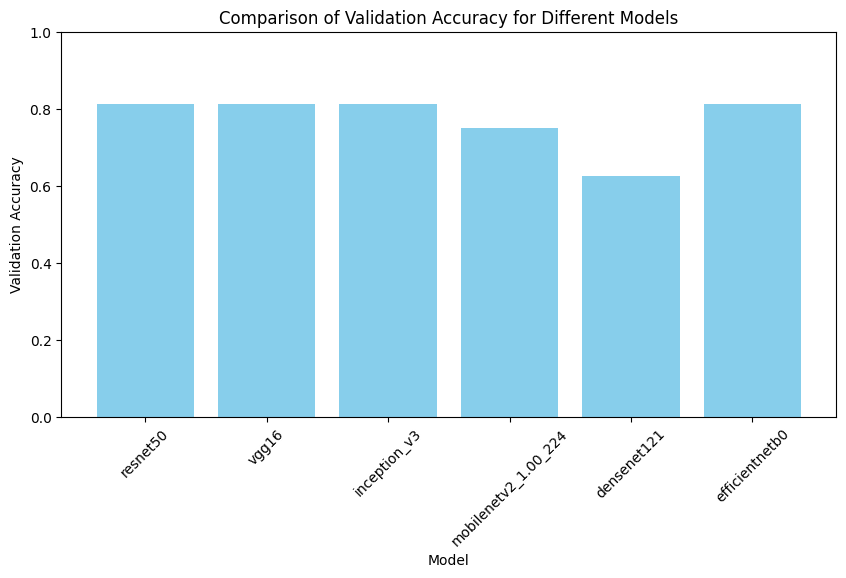

In [ ]:
for base_model in base_models:
    model = create_model(base_model)
    model_name = base_model.name

    # Define callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint(f'{model_name}.h5', monitor='val_loss', save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)
    ]
    print('training -->',model_name)
    # Train the model
    history = model.fit(
        train_generator,
        epochs=40,
        validation_data=validation_generator,
        callbacks=callbacks
    )
    model_histories[model_name] = history.history

    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(validation_generator)
    model_accuracies[model_name] = val_accuracy
    # Update the best model
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_model = model_name
    #plt.plot(history.history['val_accuracy'], label=f'{model_name} val_accuracy')
    model.save(f'best_model_{model_name}.h5')

'''plt.title('Model Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()'''
print(f'Best model: {best_model} with accuracy: {best_accuracy}')
plt.figure(figsize=(10, 5))
plt.bar(model_accuracies.keys(), model_accuracies.values(), color='skyblue')
plt.xlabel('Model')
plt.ylabel('Validation Accuracy')
plt.title('Comparison of Validation Accuracy for Different Models')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()

**MODEL TESTING**

In [ ]:
def load_model(model_name):
    base_model_map = {
        'resnet50': ResNet50,
        'vgg16': VGG16,
        'inception_v3': InceptionV3,
        'mobilenetv2_1.00_224': MobileNetV2,
        'densenet121': DenseNet121,
        'efficientnetb0': EfficientNetB0
    }
    base_model = base_model_map[model_name](weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    model = create_model(base_model)
    model.load_weights(f'{model_name}.h5')
    for layer in model.layers[-20:]:
        layer.trainable = True

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

best_model = load_model(best_model)

**CLASSIFYING OUTPUT**

In [ ]:
def predict_image(model, img_path, index_to_class):
    from tensorflow.keras.preprocessing import image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    prediction = model.predict(img_array)
    predicted_index = np.argmax(prediction)
    predicted_class_name = index_to_class[predicted_index]
    return predicted_class_name, prediction

# Example usage
img_path = '/content/plain.jpg'
predicted_class_name, probabilities = predict_image(best_model, img_path, index_to_class)
print(f'Predicted class: {predicted_class_name} with probabilities: {probabilities}')

1/1 [==============================] - 0s 24ms/step
Predicted class: male1 with probabilities: [[0.03280845 0.9671915 ]]
